In [25]:
import pickle
from importlib import reload  

import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from stellargraph.data import EdgeSplitter
from tensorflow.keras import Model, optimizers, losses, metrics, layers, models
from het_data import HetGraph
import het_data
import model
import dataset
import stellargraph as sg

from PIL import Image

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline

In [228]:
reload(dataset)
reload(model)
reload(het_data)

<module 'het_data' from '/Users/kamilwyszynski/Desktop/University/Final Year Project/implementation/het_data.py'>

In [4]:
# Creating a new dataset
num_img = 10000

hg = HetGraph()
hg.load_viz_wiz(num_img, fully_connected=False, image_threshold=0.765, word_threshold=0.535)

data = hg.get_stellar_graph()

pickle.dump(data, open(f'res/graphs/{num_img}_img_stellar_not_fc_mc.hg', 'wb'))

wn wood table Red and blue drink coaster on top of a wooden surface. The top to a K-Cup decaf Colombian coffee, sitting on a wooden desk. A used Keurig coffee pod on a wooden desk.
Added 9942 images.
Image caption:  a computer screen showing some customization and install options Customization windows are being shown on a computer screen. A computer screen that shows something being installed. Quality issues are too severe to recognize visual content. SHOW ON PRINTED WORDS ON MONITOR SHOWED BACK AND NEXT
Added 9943 images.
Image caption:  A close up of a horse's face in a stable. A horses face that is very close to the camera lens. A horse brings it's face near the camera in the barn. Appears to be an animal called horse inside a barn The up close face of a horse standing in a brown barn.
Added 9944 images.
Image caption:  Beverage in an unopened aluminum can showing Nutrition Facts. a black tin of a drink showing Nutritional facts Can of soda sitting on a wood end table. BLACK CAN OF 

In [2]:
# load graph
data = pickle.load(open('res/graphs/10000_img_stellar_not_fc_mc.hg', 'rb'))

In [3]:
print(data.info())

StellarGraph: Undirected multigraph
 Nodes: 21344, Edges: 406457

 Node types:
  word: [11344]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [10000]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    image-image2word->word: [221612]
        Weights: all 1 (default)
        Features: none
    image-image2image->image: [156432]
        Weights: range=[0.765, 1], mean=0.789674, std=0.0335917
        Features: none
    word-word2word->word: [28413]
        Weights: range=[0.535003, 0.976326], mean=0.621736, std=0.0841548
        Features: none


# Training

In [235]:
edges_train, edges_test, labels_train, labels_test, g_train, g_test = model.split_graph(data, p_test=0.3, p_train=0.1)

Network has 221612 edges of type image2word
Network has 221612 edges of type image2word
** Sampled 66483 positive and 66483 negative edges. **
Network has 155129 edges of type image2word
Network has 155129 edges of type image2word
** Sampled 15512 positive and 15512 negative edges. **


In [240]:
print(g_test.info())

StellarGraph: Undirected multigraph
 Nodes: 21344, Edges: 339974

 Node types:
  word: [11344]
    Features: float32 vector, length 300
    Edge types: word-image2word->image, word-word2word->word
  image: [10000]
    Features: float32 vector, length 512
    Edge types: image-image2image->image, image-image2word->word

 Edge types:
    image-image2image->image: [156432]
        Weights: range=[0.765, 1], mean=0.789674, std=0.0335917
        Features: none
    image-image2word->word: [155129]
        Weights: all 1 (default)
        Features: none
    word-word2word->word: [28413]
        Weights: range=[0.535003, 0.976326], mean=0.621736, std=0.0841548
        Features: none


In [241]:
num_samples=[20,4]
generator_train, generator_test, train_gen, test_gen = model.get_hinsage_generators(
    g_train, 
    g_test, 
    edges_train, 
    edges_test, 
    labels_train, 
    labels_test, 
    batch_size=50, 
    num_samples=num_samples, 
    shuffle=True,
    head_node_types=['image', 'word']
)

In [242]:
hetmodel = model.get_hinsage_model(
    generator_train, 
    train_gen, 
    test_gen, 
    num_samples=num_samples, 
    hinsage_layer_sizes=[64, 64], 
    bias=True, 
    dropout=0.0, 
    lr=1e-3, 
    edge_embedding_method='l1', 
    output_act='sigmoid'
)

link_classification: using 'l1' method to combine node embeddings into edge embeddings


2660/2660 [==============================] - 494s 185ms/step - loss: 0.6485 - binary_accuracy: 0.7806 - precision_2: 0.8578 - recall_2: 0.8827
Untrained model's Test Evaluation:
	loss: 0.6879
	binary_accuracy: 0.5507
	precision_2: 0.5305
	recall_2: 0.8824
Epoch 1/10
621/621 [==============================] - 616s 987ms/step - loss: 0.4574 - binary_accuracy: 0.8095 - precision_2: 0.8093 - recall_2: 0.8099 - val_loss: 0.3925 - val_binary_accuracy: 0.8388 - val_precision_2: 0.8421 - val_recall_2: 0.8341
Epoch 2/10
621/621 [==============================] - 603s 970ms/step - loss: 0.3781 - binary_accuracy: 0.8455 - precision_2: 0.8641 - recall_2: 0.8200 - val_loss: 0.3739 - val_binary_accuracy: 0.8462 - val_precision_2: 0.8669 - val_recall_2: 0.8179
Epoch 3/10
621/621 [==============================] - 590s 950ms/step - loss: 0.3493 - binary_accuracy: 0.8569 - precision_2: 0.8757 - recall_2: 0.8318 - val_loss: 0.3463 - val_binary_accuracy: 0.8573 - val_precision_2: 0.8739 - val_recall_2: 0

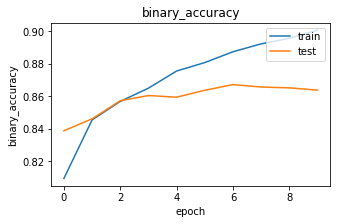

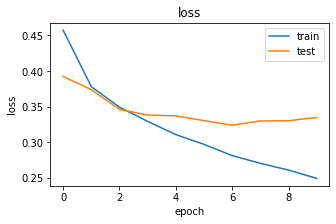

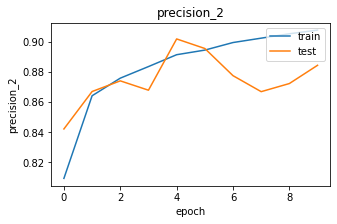

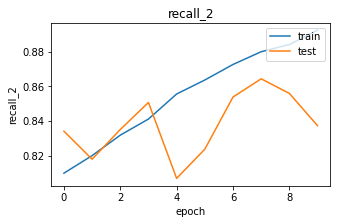

2660/2660 [==============================] - 483s 181ms/step - loss: 0.3341 - binary_accuracy: 0.8642 - precision_2: 0.8845 - recall_2: 0.8378
Test Evaluation:
	loss: 0.3341
	binary_accuracy: 0.8642
	precision_2: 0.8845
	recall_2: 0.8378
Mean Baseline Test set metrics:
	root_mean_square_error =  0.5
	mean_absolute_error =  0.5

Model Test set metrics:
	root_mean_square_error =  0.3184601528782487
	mean_absolute_error =  0.1854826285768326


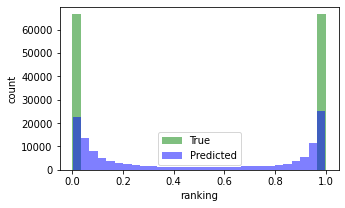

In [243]:
model.perform(hetmodel, generator_train, train_gen, test_gen, labels_test, num_workers=4, epochs=10, verbose=1, shuffle=False)

In [23]:
hetmodel.save('models/HinSAGE/test.h5')

# Model Evaluation

In [27]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
import networkx as nx
import dataset

reload(dataset)

<module 'dataset' from '/Users/kamilwyszynski/Desktop/University/Final Year Project/implementation/dataset.py'>

In [43]:
def show_images(img1, img2):

    # figure size in inches optional
    rcParams['figure.figsize'] = 5 ,3

    # read images
    img_A = mpimg.imread(os.path.join('res/vizwiz/train', img1))
    img_B = mpimg.imread(os.path.join('res/vizwiz/train', img2))

    # display images
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(img_A);
    ax[1].imshow(img_B);

In [66]:
vw = dataset.VizWiz()

In [251]:
test_pred = hetmodel.predict(test_gen)
test_pred

array([[0.03853813],
       [0.08290756],
       [0.98567516],
       ...,
       [0.03200021],
       [0.05159107],
       [0.13048926]], dtype=float32)

In [252]:
test_pred.squeeze().size

132966

In [250]:
labels_test.size

132966

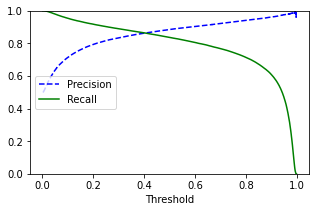

In [253]:
precisions, recalls, thresholds = precision_recall_curve(labels_test, test_pred.squeeze())

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim(0, 1)

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

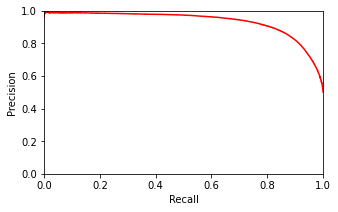

In [254]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'r-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim(0, 1)
    plt.ylim(0, 1)

plot_precision_vs_recall(precisions, recalls)

In [35]:
pred = np.where(test_pred.squeeze() > 0.5, 1, 0)

In [36]:
conf_mat = confusion_matrix(labels_test, pred)
conf_mat

array([[19024,  3137],
       [ 2949, 19212]])

In [265]:
pred = np.where(test_pred.squeeze() > 0.6, 1, 0)

In [266]:
p = precision_score(labels_test, pred)
r = recall_score(labels_test, pred)
print(f'Precision: {round(p*100,2)}%\nRecall: {round(r*100,2)}%')

# We can also calculate the F1 score
# That is, a harmonic mean of precision and recall.

# This is a measure that get's higher the more similar precision and recall values are
f1 = f1_score(labels_test, pred)

print(f'F1 score: {round(f1*100,2)}%')

Precision: 90.38%
Recall: 80.55%
F1 score: 85.18%


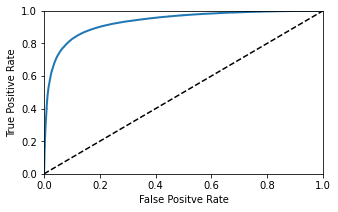

In [255]:
fpr, tpr, thresholds = roc_curve(labels_test, test_pred.squeeze())

def plot_roc(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.xlabel('False Positve Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0, 1, 0, 1])

plot_roc(fpr, tpr)

In [39]:
data.nodes(node_type='image')

array(['VizWiz_train_00000000.jpg', 'VizWiz_train_00000001.jpg',
       'VizWiz_train_00000002.jpg', ..., 'VizWiz_train_00009997.jpg',
       'VizWiz_train_00009998.jpg', 'VizWiz_train_00009999.jpg'],
      dtype=object)

In [40]:
edges_test

array([['VizWiz_train_00007772.jpg', 'keyboard'],
       ['VizWiz_train_00002992.jpg', 'plastic'],
       ['VizWiz_train_00007626.jpg', 'arthritis'],
       ...,
       ['VizWiz_train_00009139.jpg', 'noted'],
       ['VizWiz_train_00009100.jpg', '='],
       ['VizWiz_train_00006416.jpg', 'peel']], dtype=object)

In [267]:
edges_test_pred = np.concatenate((edges_test, np.expand_dims(labels_test, 1), np.expand_dims(pred, 1)), axis=1)

In [269]:
edges_test_pd = pd.DataFrame(edges_test_pred, columns = ['Image','Word','True','Pred'])
edges_test_pd

,Image,Word,True,Pred
0,VizWiz_train_00004899.jpg,larger,1,0
1,VizWiz_train_00004349.jpg,cotta,1,0
2,VizWiz_train_00006989.jpg,holding,1,1
3,VizWiz_train_00006664.jpg,control,1,1
4,VizWiz_train_00003378.jpg,room,1,1
...,...,...,...,...
132961,VizWiz_train_00002410.jpg,spiky,0,0
132962,VizWiz_train_00002901.jpg,multifunctional,0,0
132963,VizWiz_train_00003104.jpg,kickboxing,0,0
132964,VizWiz_train_00006038.jpg,sashes,0,0


In [282]:
edges_test_pd[(edges_test_pd['True'] == 1) & (edges_test_pd['Pred'] == 1)].groupby(by='Word').count()[35:]

,Image,True,Pred
Word,,,
access,2,2,2
accessory,3,3,3
acetaminophen,1,1,1
acoustic,1,1,1
across,40,40,40
...,...,...,...
yet,1,1,1
yogurt,13,13,13
z,2,2,2


In [202]:
# getting images with most test edges
edges_test_pd.groupby(by='Image').count().sort_values(by='Word', ascending=False)[25:35]

,Word,True,Pred
Image,,,
VizWiz_train_00005780.jpg,10,10,10
VizWiz_train_00006019.jpg,10,10,10
VizWiz_train_00004766.jpg,10,10,10
VizWiz_train_00008571.jpg,10,10,10
VizWiz_train_00001557.jpg,10,10,10
VizWiz_train_00007477.jpg,10,10,10
VizWiz_train_00008929.jpg,10,10,10
VizWiz_train_00003235.jpg,10,10,10
VizWiz_train_00000992.jpg,10,10,10


In [210]:
# Good examples:
# VizWiz_train_00006261 - wine
# VizWiz_train_00006677 - fingers
# VizWiz_train_00007405 - beef
# VizWiz_train_00004447 - beer
# VizWiz_train_00003959 - watermelon
# VizWiz_train_00005055 - computer screen
# VizWiz_train_00004661 - book
# VizWiz_train_00005330 - harry potter and box
tested_image = 'VizWiz_train_00008571.jpg'

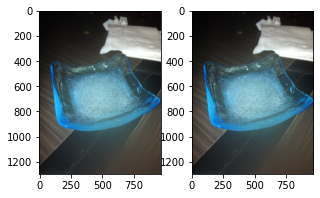

In [211]:
show_images(tested_image, tested_image)

In [212]:
vw.get_caption(tested_image)

['a blue ceramic dish or ashtray on a table',
 'a blue colored square dish made of glass',
 'A blue crystal ashtray next to napkins on a table.',
 'An ashtray is on the edge of a countertop.',
 'A blue, rectangular, thick glass bowl with the edges turned upwards is on a wooden surface with a pile of white napkins in the background.']

In [215]:
for i in g_train.in_nodes(tested_image, edge_types=['image2word']):
    print(i)

surface
colored
blue
next
crystal
background
glass
bowl
countertop
thick
made
ceramic
edge
rectangular
upwards
edges
napkins
pile


In [226]:
# See predicted and rejected edges
edges_test_pd[(edges_test_pd['True'] == 0) & (edges_test_pd['Pred'] == 0)].groupby(by='Word').count().sort_values(by='True', ascending=False)[:20]

,Image,True,Pred
Word,,,
consist,5,5,5
vibrant,5,5,5
marley,5,5,5
mower,5,5,5
sainsbury,5,5,5
fibers,5,5,5
celebrating,5,5,5
filing,5,5,5
multitude,5,5,5
